# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path
import yaml
import pandas as pd
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_metadata, convert_to_array
from lib.preprocess.file_utils import get_sample_fps, get_tile_count_from_well

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "brieflow_output/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information
- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample ND2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile", "cycle"` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phenotype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

### Data Format and Organization

- `SBS_DATA_FORMAT`/`PHENOTYPE_DATA_FORMAT`: 
  - `"nd2"`: Nikon ND2 files (most common)
  - `"tiff"`: TIFF files (requires external metadata)
  
- `SBS_DATA_ORGANIZATION`/`PHENOTYPE_DATA_ORGANIZATION`:
  - `"tile"`: Each file contains ONE field of view (FOV/position)
    - *Use when*: Files like `plate1_well_A01_tile_001.nd2`
    - *Effect*: Each tile processed separately as individual files
  - `"well"`: Each file contains MULTIPLE fields of view
    - *Use when*: Files like `plate1_well_A01.nd2` with multiple positions inside
    - *Effect*: Brieflow extracts individual positions from each multi-position file

**How to determine your organization:**
1. Open one of your ND2 files in ImageJ/Fiji
2. Check if it shows multiple "Series" or "Positions"
   - Multiple positions → use `"well"`
   - Single position → use `"tile"`

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- Numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample file path should have an associated plate/well. For single plate/well screens, manually add a plate/well to the file path dataframe.

In [3]:
# Paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"
# Paths to combination dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"
# Paths to image directories
SBS_IMAGES_DIR_FP = Path("/archive/cheeseman/brieflow_screens/cotopaxi/input_sbs/")
PHENOTYPE_IMAGES_DIR_FP = Path("/archive/cheeseman/brieflow_screens/cotopaxi/input_ph/")

# SBS pattern configurations
SBS_PATH_PATTERN = r"c(\d+)/\d+_\d+_\d+/Well([A-Z]\d+)_Channel([A-Za-z0-9_-]+)_Seq\d+\.nd2"
SBS_PATH_METADATA = ["cycle", "well", "channel"]
SBS_METADATA_ORDER_TYPE = {
    "well": str,
    "cycle": int,
    "channel": str
}

# Phenotype pattern configurations
PHENOTYPE_PATH_PATTERN = r"20220629_165010_675/Well([A-Z]\d+)_Channel((?:GFP_1x1-DAPI_1x1|A594_1x1|AF750_1x1))_Seq\d+\.nd2"
PHENOTYPE_PATH_METADATA = ["well", "channel"]
PHENOTYPE_METADATA_ORDER_TYPE = {
    "well": str,
    "channel": str
}

# Data format and organization
SBS_DATA_FORMAT = "nd2"  
SBS_DATA_ORGANIZATION = "well"
PHENOTYPE_DATA_FORMAT = "nd2"
PHENOTYPE_DATA_ORGANIZATION = "well"

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

## Create Sample DFs

In [4]:
# Create SBS samples DataFrame (always)
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
sbs_samples.insert(0, "plate", 1) # TODO: remove this, temporary fix.
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create SBS wildcard combos based on data organization
if SBS_DATA_ORGANIZATION == "tile":
    sbs_wildcard_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
    sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
    print("SBS wildcard combos (tile organization):")
    display(sbs_wildcard_combos)
elif SBS_DATA_ORGANIZATION == "well" and len(sbs_samples) > 0:
    print("SBS: Detecting tile count for well organization...")
    # Get tile count from a sample well
    SBS_TILES = get_tile_count_from_well(
        sbs_samples,
        plate=sbs_samples["plate"].iloc[0],
        well=sbs_samples["well"].iloc[0],
        cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
        verbose=True
    )
    print(f"Detected {SBS_TILES} tiles per well for SBS")
    
    SBS_PATH_METADATA  = ["plate", "cycle", "well", "channel"] # TODO: remove this, temporary fix.
    # Generate combos with detected tile count
    base_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
    tiles = [str(i) for i in range(SBS_TILES)]
    sbs_wildcard_combos = pd.DataFrame([
        {**row.to_dict(), "tile": tile}
        for _, row in base_combos.iterrows()
        for tile in tiles
    ])
    sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
    print("SBS wildcard combos (well organization):")
    display(sbs_wildcard_combos)

# Create phenotype samples DataFrame (always)
phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_PATH_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
)
phenotype_samples.insert(0, "plate", 1) # TODO: remove this, temporary fix.
phenotype_samples.insert(1, "round", 1) # TODO: remove this, temporary fix.
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

# Create phenotype wildcard combos based on data organization
if PHENOTYPE_DATA_ORGANIZATION == "tile":
    phenotype_wildcard_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
    phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
    print("Phenotype wildcard combos (tile organization):")
    display(phenotype_wildcard_combos)
elif PHENOTYPE_DATA_ORGANIZATION == "well" and len(phenotype_samples) > 0:
    print("Phenotype: Detecting tile count for well organization...")
    # Get tile count from a sample well
    PHENOTYPE_TILES = get_tile_count_from_well(
        phenotype_samples,
        plate=phenotype_samples["plate"].iloc[0],
        well=phenotype_samples["well"].iloc[0],
        verbose=True
    )
    print(f"Detected {PHENOTYPE_TILES} tiles per well for phenotype")
    
    PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "channel"] # TODO: remove this, temporary fix.
    # Generate combos with detected tile count
    base_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
    tiles = [str(i) for i in range(PHENOTYPE_TILES)]
    phenotype_wildcard_combos = pd.DataFrame([
        {**row.to_dict(), "tile": tile}
        for _, row in base_combos.iterrows()
        for tile in tiles
    ])
    phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
    print("Phenotype wildcard combos (well organization):")
    display(phenotype_wildcard_combos)

SBS samples:


,plate,sample_fp,well,cycle,channel
0,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,1,DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p
1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,2,A594_30p
2,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,2,CY3_30p
3,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,2,CY5_30p
4,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,2,CY7_30p
...,...,...,...,...,...
193,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,B3,8,CY7_30p
194,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,B3,9,A594_30p
195,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,B3,9,CY3_30p
196,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,B3,9,CY5_30p


SBS: Detecting tile count for well organization...

Processing file: /archive/cheeseman/brieflow_screens/cotopaxi/input_sbs/c1/20220701_121949_242/WellA1_ChannelDAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File dimensions: {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (5, 1480, 1480)
Final dimensions (CYX): (5, 1480, 1480)
Array size in bytes: 21904000
Detected 333 tiles per well for SBS
SBS wildcard combos (well organization):


,plate,cycle,well,channel,tile
0,1,1,A1,DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p,0
1,1,1,A1,DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p,1
2,1,1,A1,DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p,2
3,1,1,A1,DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p,3
4,1,1,A1,DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p,4
...,...,...,...,...,...
65929,1,9,B3,CY7_30p,328
65930,1,9,B3,CY7_30p,329
65931,1,9,B3,CY7_30p,330
65932,1,9,B3,CY7_30p,331


Phenotype samples:


,plate,round,sample_fp,well,channel
0,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,A594_1x1
1,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,AF750_1x1
2,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A1,GFP_1x1-DAPI_1x1
3,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A2,A594_1x1
4,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A2,AF750_1x1
5,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A2,GFP_1x1-DAPI_1x1
6,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A3,A594_1x1
7,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A3,AF750_1x1
8,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,A3,GFP_1x1-DAPI_1x1
9,1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,B1,A594_1x1


Phenotype: Detecting tile count for well organization...

Processing file: /archive/cheeseman/brieflow_screens/cotopaxi/input_ph/20220629_165010_675/WellA1_ChannelA594_1x1_Seq0001.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes
Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)
Final dimensions (CYX): (1, 2960, 2960)
Array size in bytes: 17523200
Detected 1281 tiles per well for phenotype
Phenotype wildcard combos (well organization):


,plate,round,well,channel,tile
0,1,1,A1,A594_1x1,0
1,1,1,A1,A594_1x1,1
2,1,1,A1,A594_1x1,2
3,1,1,A1,A594_1x1,3
4,1,1,A1,A594_1x1,4
...,...,...,...,...,...
23053,1,1,B3,GFP_1x1-DAPI_1x1,1276
23054,1,1,B3,GFP_1x1-DAPI_1x1,1277
23055,1,1,B3,GFP_1x1-DAPI_1x1,1278
23056,1,1,B3,GFP_1x1-DAPI_1x1,1279


## <font color='red'>SET PARAMETERS</font>

### Metadata Source Configuration

- `SBS_METADATA_*`/`PHENOTYPE_METADATA_*`: Configuration for external metadata files containing positional and imaging metadata.
 - **For TIFF files**: Usually required (e.g., `coordinates.csv`, `metadata.tsv`)
 - **For ND2 files**: Usually set directories to `None` (metadata extracted from ND2 headers)
 - **For OME-Zarr files**: Usually set directories to `None` (metadata in OME metadata)

**Metadata File Organization:**
- `*_METADATA_IMAGES_DIR_FP`: Base directory containing metadata files
- `*_METADATA_PATH_PATTERN`: Regex pattern to find metadata files
- `*_METADATA_PATH_METADATA`: Metadata to extract from file paths
- `*_METADATA_SAMPLES_DF_FP`: Where to save the metadata file inventory

In [5]:
# Set metadata extraction parameters
SBS_METADATA_IMAGES_DIR_FP = None
SBS_METADATA_PATH_PATTERN = None
SBS_METADATA_PATH_METADATA = None
SBS_METADATA_ORDER_TYPE = None
SBS_METADATA_SAMPLES_DF_FP = None

PHENOTYPE_METADATA_IMAGES_DIR_FP = None
PHENOTYPE_METADATA_PATH_PATTERN = None
PHENOTYPE_METADATA_PATH_METADATA = None
PHENOTYPE_METADATA_ORDER_TYPE = None
PHENOTYPE_METADATA_SAMPLES_DF_FP = None

In [6]:
# Generate SBS metadata samples table
if SBS_METADATA_IMAGES_DIR_FP is not None:
    print("Generating SBS metadata file inventory...")
    sbs_metadata_samples = create_samples_df(
        SBS_METADATA_IMAGES_DIR_FP, 
        SBS_METADATA_PATH_PATTERN, 
        SBS_METADATA_PATH_METADATA, 
        SBS_METADATA_ORDER_TYPE
    )
    sbs_metadata_samples.to_csv(SBS_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("SBS metadata files found:")
    display(sbs_metadata_samples)
else:
    print("SBS: No external metadata files - will extract from image files")
    sbs_metadata_samples = pd.DataFrame()

# Generate phenotype metadata samples table
if PHENOTYPE_METADATA_IMAGES_DIR_FP is not None:
    print("\nGenerating phenotype metadata file inventory...")
    phenotype_metadata_samples = create_samples_df(
        PHENOTYPE_METADATA_IMAGES_DIR_FP,
        PHENOTYPE_METADATA_PATH_PATTERN,
        PHENOTYPE_METADATA_PATH_METADATA,
        PHENOTYPE_METADATA_ORDER_TYPE
    )
    phenotype_metadata_samples.to_csv(PHENOTYPE_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("Phenotype metadata files found:")
    display(phenotype_metadata_samples)
else:
    print("Phenotype: No external metadata files - will extract from ND2 files")
    phenotype_metadata_samples = pd.DataFrame()

SBS: No external metadata files - will extract from image files
Phenotype: No external metadata files - will extract from ND2 files


## Test Metadata Extraction

In [7]:
if len(sbs_samples) > 0:
    print("Testing SBS metadata extraction...")
    
    # Get metadata file for this specific sample
    if len(sbs_metadata_samples) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            sbs_metadata_samples,
            plate=sbs_samples["plate"].iloc[0],
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None  # <-- FIX: Define the variable here too
        print("No metadata files - extracting from image files")
    
    # Extract metadata using unified function
    test_sbs_metadata = extract_metadata(
        sbs_samples["sample_fp"].iloc[0],
        plate=sbs_samples["plate"].iloc[0],
        well=sbs_samples["well"].iloc[0],
        tile=sbs_samples["tile"].iloc[0] if "tile" in sbs_samples.columns else 0,
        cycle=sbs_samples.get("cycle", [None]).iloc[0],
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

# Test phenotype metadata extraction  
if len(phenotype_samples) > 0:
    print("\nTesting phenotype metadata extraction...")
    
    # Get metadata file for this specific sample (if any)
    if len(phenotype_metadata_samples) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            phenotype_metadata_samples,
            plate=phenotype_samples["plate"].iloc[0],
            round=phenotype_samples["round"].iloc[0] if "round" in phenotype_samples.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None  # <-- FIX: Define the variable here too
        print("No metadata files - extracting from ND2 files")
    
    # Extract metadata using unified function
    test_phenotype_metadata = extract_metadata(
        phenotype_samples["sample_fp"].iloc[0],
        plate=phenotype_samples["plate"].iloc[0],
        well=phenotype_samples["well"].iloc[0],
        tile=phenotype_samples["tile"].iloc[0] if "tile" in phenotype_samples.columns else 0,
        round=phenotype_samples["round"].iloc[0] if "round" in phenotype_samples.columns else None,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Testing SBS metadata extraction...
No metadata files - extracting from image files
Processing well file: /archive/cheeseman/brieflow_screens/cotopaxi/input_sbs/c1/20220701_121949_242/WellA1_ChannelDAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File shape: (333, 5, 1480, 1480)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Number of positions: 333
Number of Z planes: 1
SBS test metadata:


,x_pos,y_pos,z_pos,pfs_offset,plate,well,tile,filename,channels,cycle,pixel_size_x,pixel_size_y
0,41578.1,-35603.5,3040.64,None,1,A1,0,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
1,40050.5,-35595.4,3040.72,None,1,A1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
2,38522.8,-35586.9,3040.80,None,1,A1,2,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
3,36995.5,-35578.8,3040.84,None,1,A1,3,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
4,35467.8,-35570.8,3040.86,None,1,A1,4,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
...,...,...,...,...,...,...,...,...,...,...,...,...
328,41741.2,-5052.6,2998.10,None,1,A1,328,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
329,40213.5,-5044.2,2998.16,None,1,A1,329,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
330,38686.0,-5036.3,2994.06,None,1,A1,330,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286
331,37158.5,-5028.0,2993.60,None,1,A1,331,/archive/cheeseman/brieflow_screens/cotopaxi/i...,5,1,1.214286,1.214286



Testing phenotype metadata extraction...
No metadata files - extracting from ND2 files
Processing well file: /archive/cheeseman/brieflow_screens/cotopaxi/input_ph/20220629_165010_675/WellA1_ChannelA594_1x1_Seq0001.nd2
File shape: (1281, 4, 2960, 2960)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Number of positions: 1281
Number of Z planes: 4
Phenotype test metadata:


,x_pos,y_pos,z_pos,pfs_offset,plate,well,tile,filename,channels,round,pixel_size_x,pixel_size_y
0,40802.0,-35596.1,4176.34,None,1,A1,0,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
1,40038.7,-35592.0,4177.68,None,1,A1,1,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
2,39274.7,-35588.2,4177.04,None,1,A1,2,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
3,38510.9,-35584.0,4177.04,None,1,A1,3,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
4,37747.2,-35579.9,4176.98,None,1,A1,4,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
...,...,...,...,...,...,...,...,...,...,...,...,...
1276,39437.7,-5037.4,4132.04,None,1,A1,1276,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
1277,38673.8,-5033.0,4131.74,None,1,A1,1277,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
1278,37910.1,-5028.7,4131.50,None,1,A1,1278,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571
1279,37146.1,-5024.7,4131.20,None,1,A1,1279,/archive/cheeseman/brieflow_screens/cotopaxi/i...,1,1,0.303571,0.303571


## <font color='red'>SET PARAMETERS</font>

### Image conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [8]:
SBS_CHANNEL_ORDER = ["DAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p", "CY3_30p", "A594_30p", "CY5_30p", "CY7_30p"]
PHENOTYPE_CHANNEL_ORDER = ["GFP_1x1-DAPI_1x1", "A594_1x1", "AF750_1x1"]
PHENOTYPE_ROUND_ORDER = [1]
SBS_CHANNEL_ORDER_FLIP = False
PHENOTYPE_CHANNEL_ORDER_FLIP = True

## Test Image Conversion

### Test SBS conversion

Testing SBS image conversion...

Processing file: /archive/cheeseman/brieflow_screens/cotopaxi/input_sbs/c1/20220701_121949_242/WellA1_ChannelDAPI-CY3_30p-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File dimensions: {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (5, 1480, 1480)
Final dimensions (CYX): (5, 1480, 1480)
Array size in bytes: 21904000
SBS converted image shape: (5, 1480, 1480)


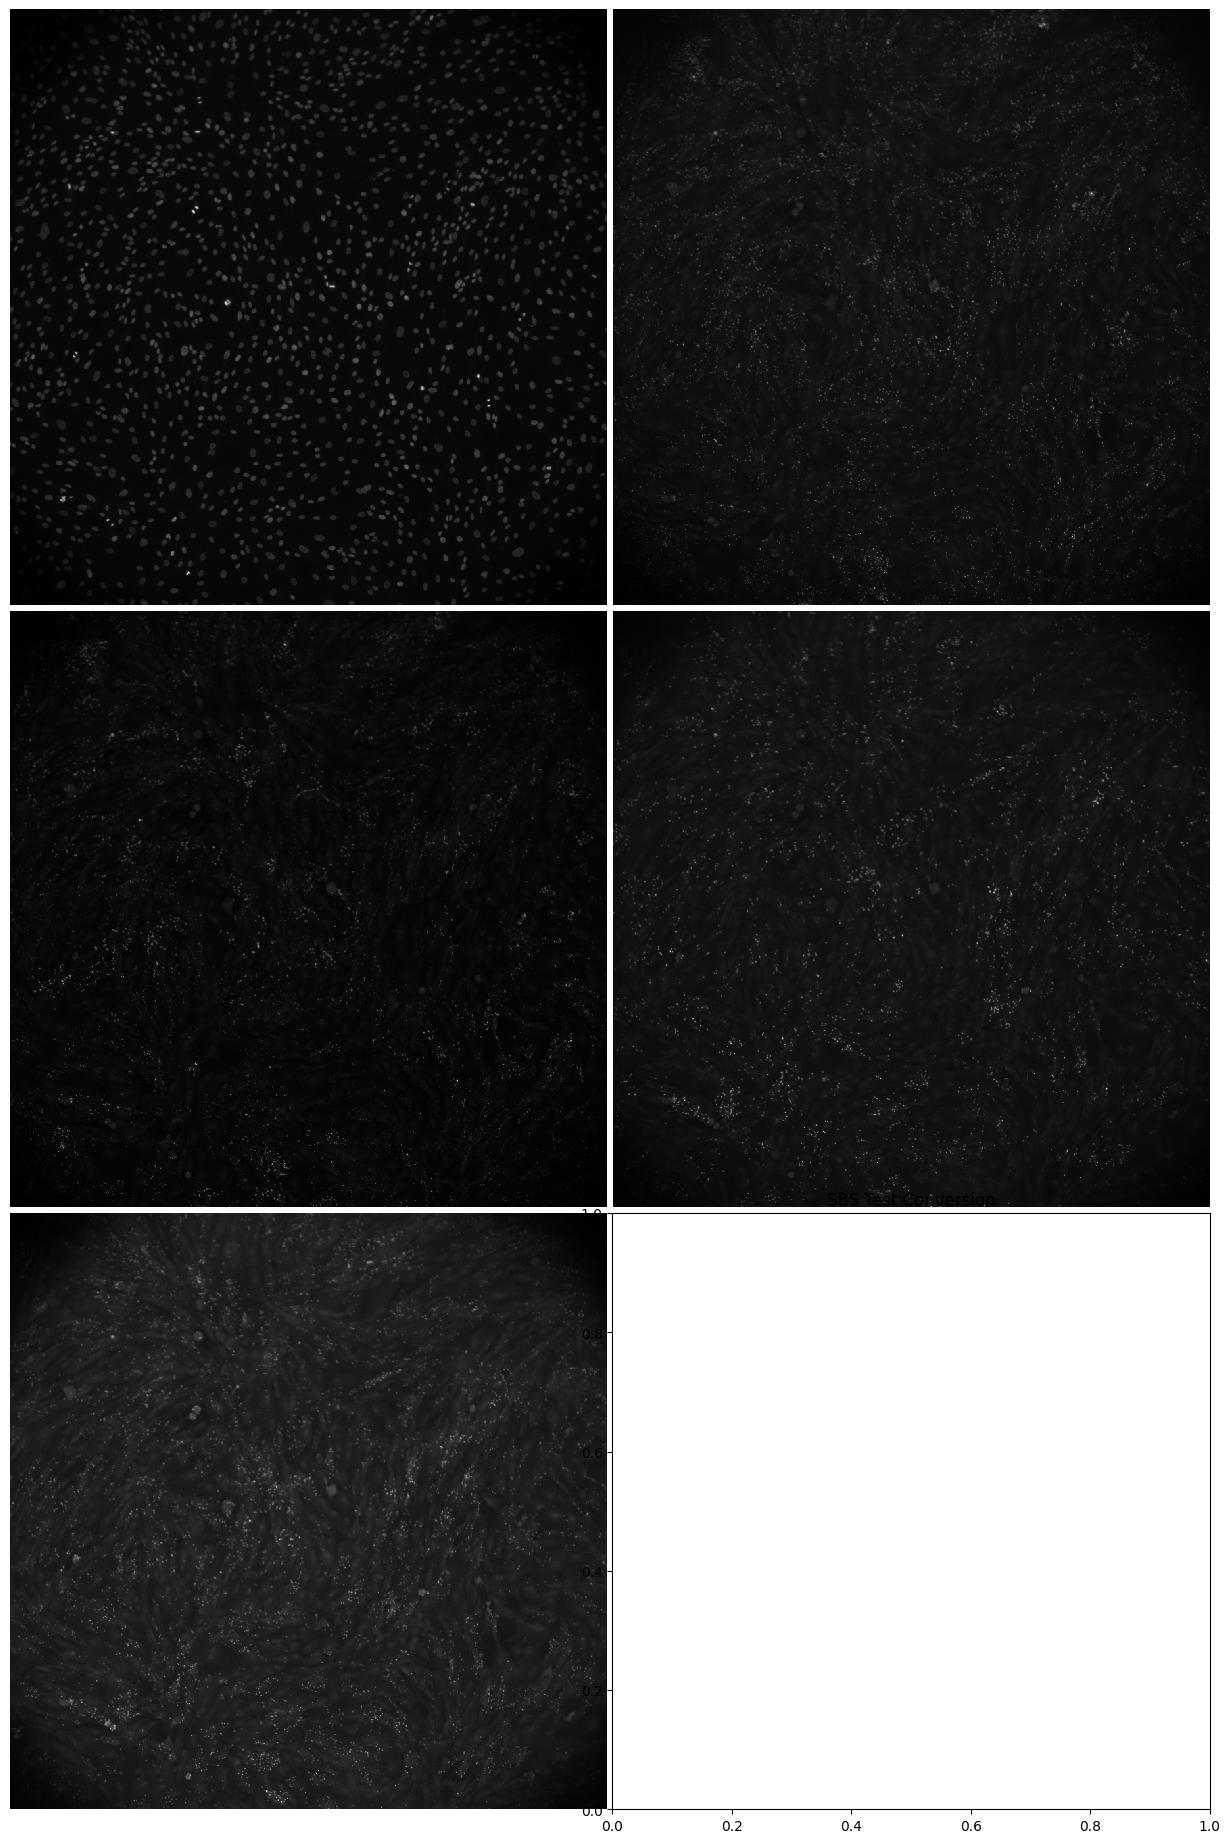

In [9]:
if len(sbs_samples) > 0:
    print("Testing SBS image conversion...")
    
    # Get sample files based on data organization
    if SBS_DATA_ORGANIZATION == "tile":
        sbs_sample_files = get_sample_fps(
            sbs_samples,
            plate=sbs_samples["plate"].iloc[0],
            well=sbs_samples["well"].iloc[0],
            tile=sbs_samples["tile"].iloc[0] if "tile" in sbs_samples.columns else 0,
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
    else:  # well organization
        sbs_sample_files = get_sample_fps(
            sbs_samples,
            plate=sbs_samples["plate"].iloc[0],
            well=sbs_samples["well"].iloc[0],
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
        
    # Convert using unified function
    sbs_image = convert_to_array(
        sbs_sample_files,
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        position=0 if SBS_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=SBS_CHANNEL_ORDER_FLIP,
        verbose=True
    )
    
    print(f"SBS converted image shape: {sbs_image.shape}")
    
    # Display images
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.title("SBS Test Conversion")
    plt.show()

### Test phenotype conversion

Testing phenotype image conversion...

Processing file: /archive/cheeseman/brieflow_screens/cotopaxi/input_ph/20220629_165010_675/WellA1_ChannelGFP_1x1-DAPI_1x1_Seq0002.nd2
File dimensions: {'P': 1281, 'Z': 4, 'C': 2, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes
Z-stack shape: (4, 2, 2960, 2960)
Frame shape after Z processing: (2, 2960, 2960)

Processing file: /archive/cheeseman/brieflow_screens/cotopaxi/input_ph/20220629_165010_675/WellA1_ChannelA594_1x1_Seq0001.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes
Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)

Processing file: /archive/cheeseman/brieflow_screens/cotopaxi/input_ph/20220629_165010_675/WellA1_ChannelAF750_1x1_Seq0000.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes
Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)
Final dimensions (CYX): (4, 2960, 2960)
Array size in bytes:

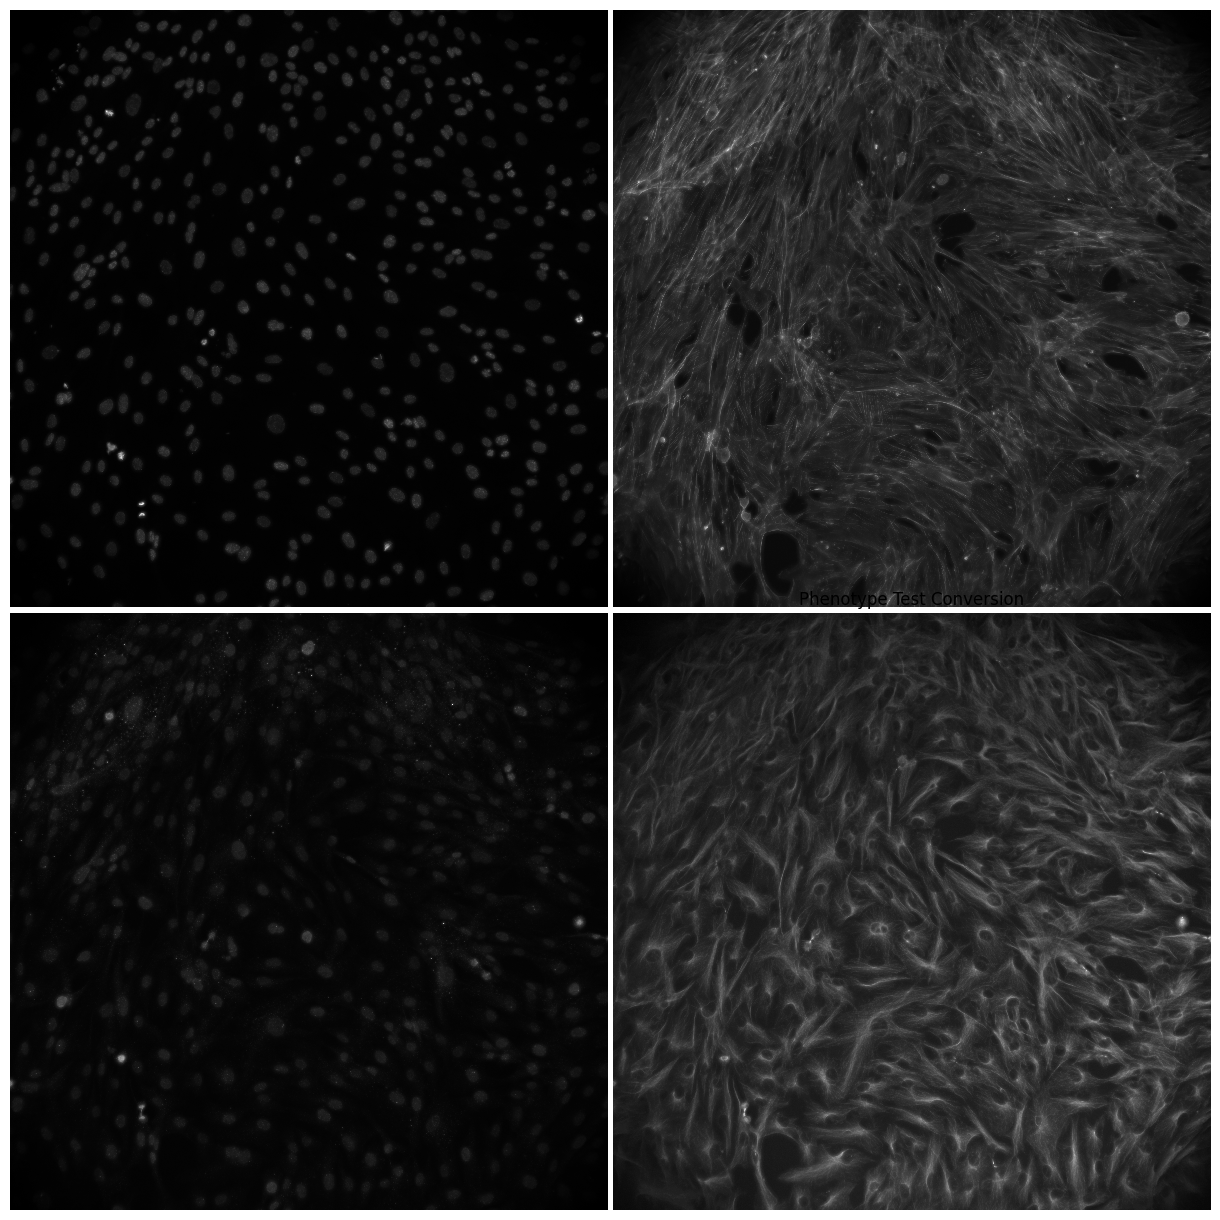

In [10]:
if len(phenotype_samples) > 0:
    print("Testing phenotype image conversion...")
    
    # Get sample files based on data organization
    if PHENOTYPE_DATA_ORGANIZATION == "tile":
        phenotype_sample_files = get_sample_fps(
            phenotype_samples,
            plate=phenotype_samples["plate"].iloc[0],
            well=phenotype_samples["well"].iloc[0],
            tile=phenotype_samples["tile"].iloc[0] if "tile" in phenotype_samples.columns else 0,
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
    else:  # well organization
        phenotype_sample_files = get_sample_fps(
            phenotype_samples,
            plate=phenotype_samples["plate"].iloc[0],
            well=phenotype_samples["well"].iloc[0],
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
      
    # Convert using unified function
    phenotype_image = convert_to_array(
        phenotype_sample_files,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        position=0 if PHENOTYPE_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP,
        verbose=True
    )
    
    print(f"Phenotype converted image shape: {phenotype_image.shape}")
    
    # Display images
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.title("Phenotype Test Conversion")
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [11]:
SAMPLE_FRACTION = 0.5

## Create config file with params

In [12]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    # File paths
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    
    # SBS configuration
    "sbs_data_format": SBS_DATA_FORMAT,
    "sbs_data_organization": SBS_DATA_ORGANIZATION,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "sbs_metadata_samples_df_fp": SBS_METADATA_SAMPLES_DF_FP,
    
    # Phenotype configuration
    "phenotype_data_format": PHENOTYPE_DATA_FORMAT,
    "phenotype_data_organization": PHENOTYPE_DATA_ORGANIZATION,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "phenotype_metadata_samples_df_fp": PHENOTYPE_METADATA_SAMPLES_DF_FP,

    # Processing parameters
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)